<a href="https://colab.research.google.com/github/gpenessot/OCT23_BDS_Radios_Poumons/blob/main/3_Thibaut_Mod%C3%A9lisation_4_Evaluation_%26_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet DST radio : Charger, évaluer et interpréter les résultats d'un modèle

### a) Import des librairies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import time
import os
import pathlib
import shutil
import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
import pickle
from tensorflow.keras import datasets, layers, models, losses
import datetime
# Display
from IPython.display import Image, display
import matplotlib.cm as cm

### b) Import d'un modèle enregistré avec ses résultats

In [ ]:
# à mettre à jour pour chaque modèle évalué
#L'import des résultats (pickle.load) n'est pas nécessaire pour le Grad-CAM, il nécessite d'avoir enregistré les résultats au moment de sauver le modèle (ce n'est pas intégré dans les fichiers keras.)

model = keras.models.load_model("/content/drive/My Drive/DST_projet_radio/Models/LeNet-valacc0.67-dataset4000.keras")
#charger les résultats enregistrés
with open("/content/drive/My Drive/DST_projet_radio/Models/LeNet-valacc0.67-dataset4000_history.pkl", 'rb') as f:
    history = pickle.load(f)
# Show the model architecture
model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 random_contrast (RandomCon  (None, 256, 256, 1)       0         
 trast)                                                          
                                                                 
 Conv1 (Conv2D)              (None, 252, 252, 30)      780       
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 30)      0         
 D)                                                              
                                                                 
 DO1 (Dropout)               (None, 126, 126, 30)      0         
                                                                 
 Conv2 (Conv2D)              (None, 124, 124, 16)      4336  

### d) Import du jeu de test



Keras doesn't provide any more advanced feature than just taking a fraction of your training data for validation. If you need something more advanced, like stratified sampling to make sure classes are well represented in the sample, then you need to do this manually outside of Keras (using say, scikit-learn or numpy) and then pass that validation data to keras through the validation_data parameter in model.fit


In [ ]:
#Evaluate on test set : chargement du jeu de test
#1 : Indiquer le dossier et compter le nb d'images dans le dataset
dossier_test = "/content/drive/My Drive/DST_projet_radio/Datasets/Test_set_800"
test_dir = pathlib.Path(dossier_test).with_suffix('')
image_count = len(list(test_dir.glob('*/*.png')))
print(f"{image_count} images dans le dataset de test")

#2 : Chargement du dataset dans Keras
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(256, 256),
  color_mode = "grayscale")

804 images dans le dataset de test
Found 804 files belonging to 4 classes.


In [ ]:
class_names = test_ds.class_names
num_classes = len(class_names)
print(class_names)

['COVID', 'LUNG OPACITY', 'NORMAL', 'VIRAL PNEUMONIA']


### C) Facultatif : Affichage des courbes d'entraînement du modèle (si l'historique de résultat a été chargé avec le modèle)

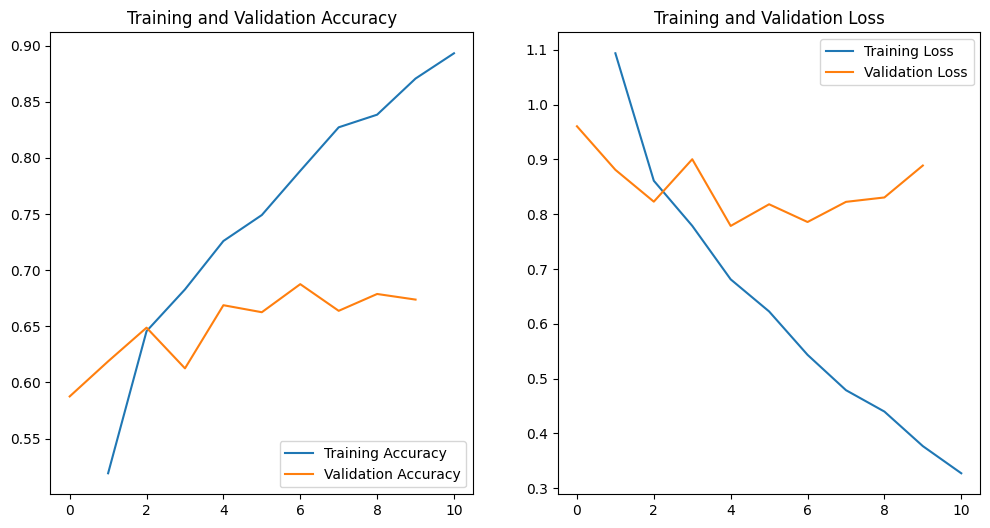

In [ ]:
#Visualize training results
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(history.history['accuracy'])+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Métriques sur jen d'entraînement
best_val_loss_index = np.argmin(history.history["val_loss"])
print("Best validation loss :", round(np.max(history.history["val_loss"]), 2) )
print("Validation accuracy : ", round(history.history["val_accuracy"][best_val_loss_index], 2))
print("Obtained at epoch : ", best_val_loss_index + 1)

Best validation loss : 0.96
Validation accuracy :  0.67
Obtained at epoch :  5


### d) Evaluer le modèle sur un jeu de test

In [ ]:
#Métriques sur jeu de test
model.evaluate(test_ds, return_dict=True)

26/26 [==============================] - 268s 6s/step - loss: 0.8104 - accuracy: 0.6580


{'loss': 0.8104214668273926, 'accuracy': 0.6579601764678955}

### e) Visualiser les prédictions et scores sur plusieurs images

1/1 [==============================] - 0s 27ms/step


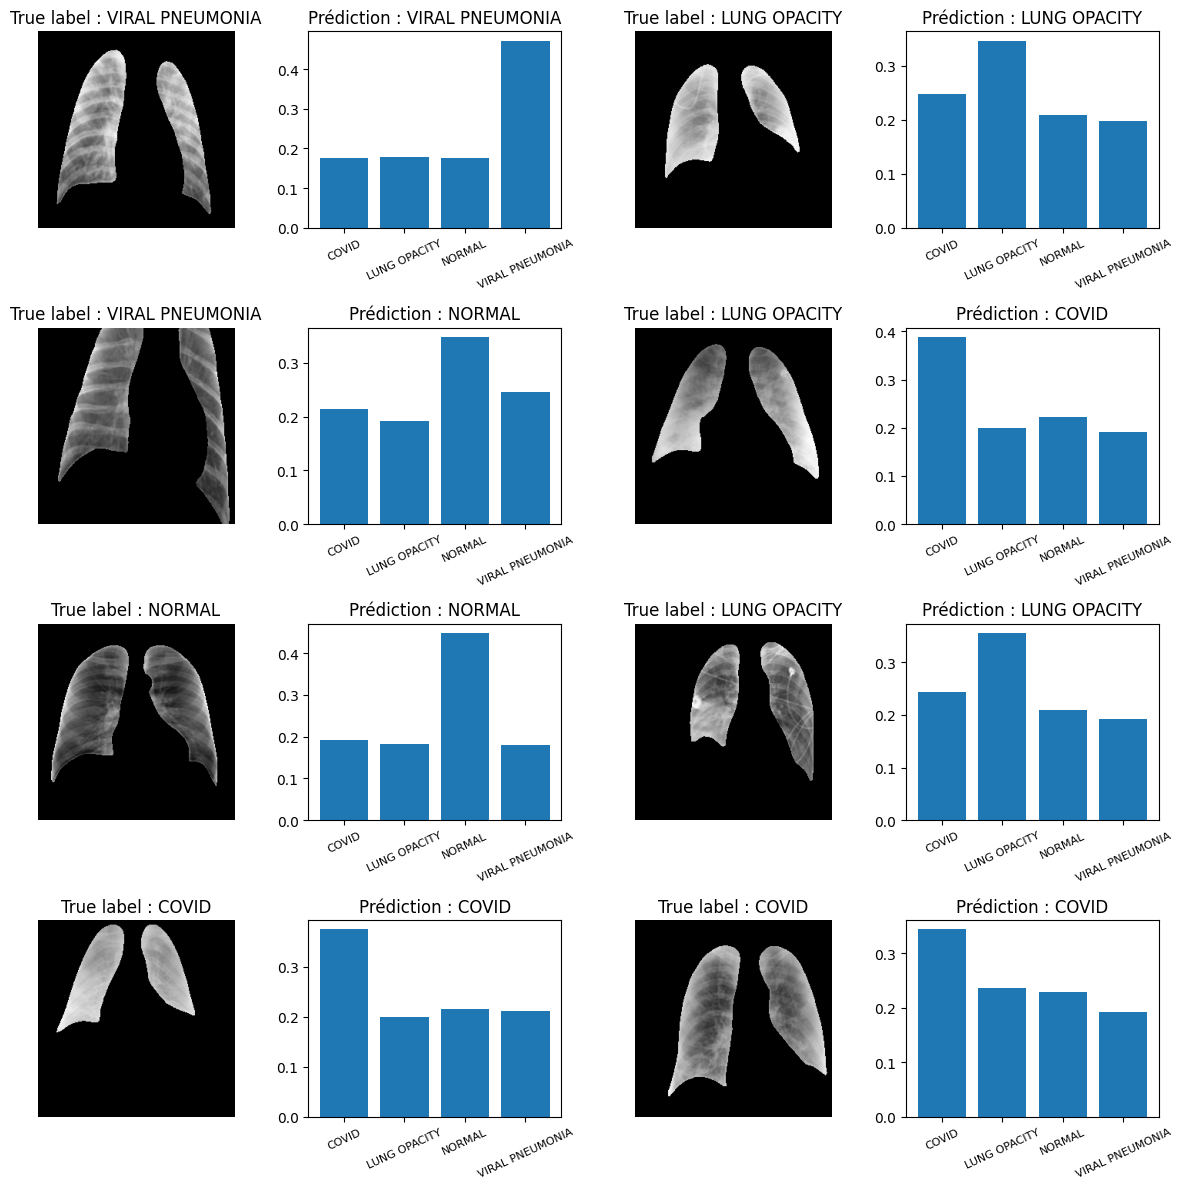

In [ ]:
#set grid size
num_rows = 4
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(2*3*num_cols, 3*num_rows))

#Itérer sur le nombre d'images souhaité
for i in range(num_images):
  #Tirer une image du test dataset au hasard
  for image, label in test_ds.take(1):
    prediction = model.predict(image)[0]
    score = tf.nn.softmax(prediction)
  #  print("Probabilités par classe : ", list(zip(class_names, score.numpy().round(2))))

    #Afficher l'image
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.imshow(image[0] / 255.0, cmap = "gray")
    title1 = "True label : " + str(class_names[label[0].numpy()])
    plt.title(title1)
    #Vérifier la prédiction de manière graphique
    plt.axis("off")

    #Afficher le graphique à barre avec les probabilités par classe
    plt.subplot(num_rows, 2*num_cols , 2*i+2)
    plt.bar(class_names, score.numpy())
    title2 = f"Prédiction : {class_names[np.argmax(prediction)]}"
    plt.title(title2)
    plt.xticks(rotation=25, fontsize = 8)

plt.tight_layout()
plt.show()

### f) Interprétation par l'algo Grad-CAM

In [ ]:
#Fonction GRAD CAM (inspiré de l'exemple du site de Keras)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
def superimpose(img_array, heatmap, alpha=0.4):
    # Load the original image sous forme d'array (1,)
    img_array = img_array.reshape(256,256,1)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    return superimposed_img




<ipython-input-90-1c3f48734cbc>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


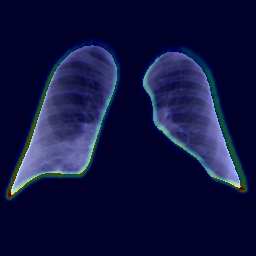

In [ ]:
#Test sur 1 image

#Image
for image, label in test_ds.take(1):
  img_array = np.expand_dims(image[0], axis=0)
  last_conv_layer_name = "Conv2"
  # Remove last layer's softmax (copy the model first)
  model_for_CAM = model
  model_for_CAM.layers[-1].activation = None
  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model_for_CAM, last_conv_layer_name)
  display(superimpose(img_array, heatmap, alpha=0.4))

1/1 [==============================] - 0s 30ms/step


<ipython-input-90-1c3f48734cbc>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1/1 [==============================] - 0s 30ms/step


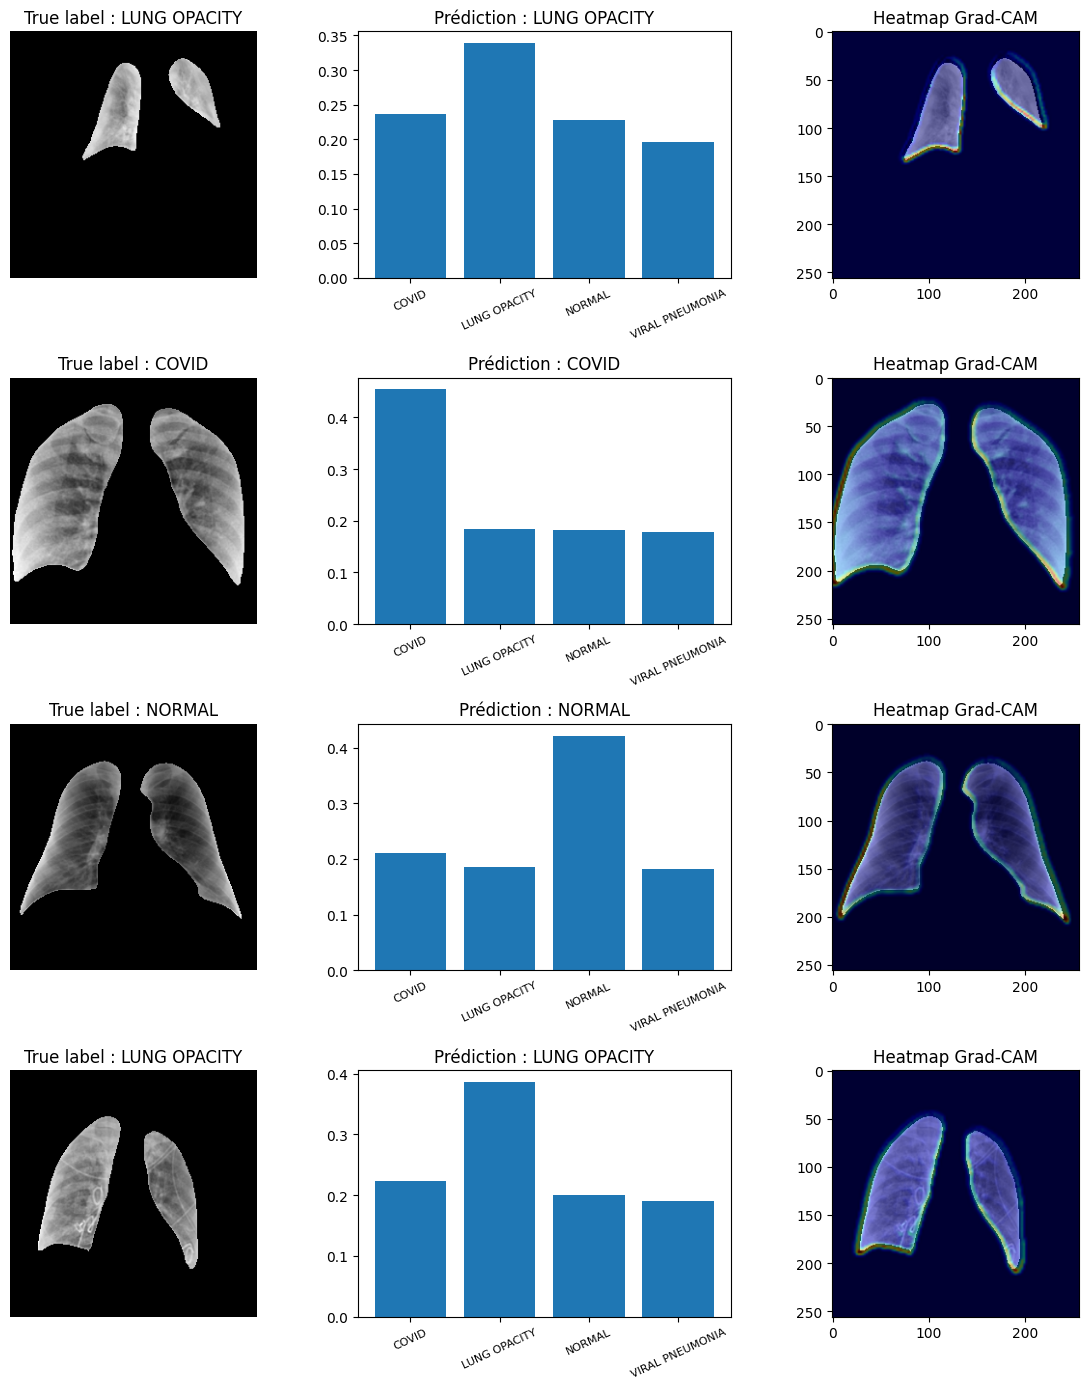

In [ ]:
#Créer une grille d'images et afficher l'image, la prédiction et la heatmap

#set grid size
num_rows = 4
num_cols = 1
# 3 représentations pour chaque image : l'image, la heatmap, le graphique à barres
num_images = num_rows * num_cols
plt.figure(figsize=(3.5*3.5*num_cols, 3.5*num_rows))

#Itérer sur le nombre d'images souhaité
for i in range(num_images):
  #Tirer une image du test dataset au hasard
  for image, label in test_ds.take(1):
    prediction = model.predict(image)[0]
    score = tf.nn.softmax(prediction)
  #  print("Probabilités par classe : ", list(zip(class_names, score.numpy().round(2))))
    #Calcul des paramètres pour la fonction Grad Cam
    img_array = np.expand_dims(image[0], axis=0)
    model_for_CAM = model
    # Remove last layer's softmax (copy the model first)
    model_for_CAM.layers[-1].activation = None
    last_conv_layer_name = "Conv2"
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model_for_CAM, last_conv_layer_name)

    #Afficher l'image
    plt.subplot(num_rows, 3*num_cols, 3*i+1)
    plt.imshow(image[0] / 255.0, cmap = "gray")
    title1 = "True label : " + str(class_names[label[0].numpy()])
    plt.title(title1)
    #Vérifier la prédiction de manière graphique
    plt.axis("off")

    #Afficher le graphique à barre avec les probabilités par classe
    plt.subplot(num_rows, 3*num_cols , 3*i+2)
    plt.bar(class_names, score.numpy())
    title2 = f"Prédiction : {class_names[np.argmax(prediction)]}"
    plt.title(title2)
    plt.xticks(rotation=25, fontsize = 8)

    #Afficher la heatmap de la fonction GradCam superposée
    plt.subplot(num_rows, 3*num_cols, 3*i+3)
    plt.title("Heatmap Grad-CAM")
    plt.imshow(superimpose(img_array, heatmap, alpha=0.4))



plt.tight_layout()
plt.show()